# MTS Gold Price

## First Steps

### Import Libraries

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px # type: ignore

In [77]:
import sys
sys.path.append('..')

In [78]:
from utils.plot import plot_time_series
from utils.preds import evaluate_preds

### Fetch Data

In [79]:
dirname = os.path.join(os.getcwd(), '..', 'data', 'Gold_Price.csv')

In [80]:
gold_price = pd.read_csv(dirname, header=0, index_col=0)
gold_price.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2025-01-06,77149,77309,77542,76545,27160,0.44
2025-01-03,76813,77246,78600,76613,60,-0.05
2025-01-02,76849,76849,76849,76849,0,0.83
2025-01-01,76214,76232,76302,76053,60,-0.02
2024-12-31,76232,75680,76970,75572,1920,0.95


### Clean the Data

In [81]:
gold_price.shape

(2848, 6)

In [82]:
# Check out if there is some NA in our dataframe
gold_price.isna().any().any()

np.False_

In [83]:
# Let's conver the index into datetime
gold_price.index = pd.to_datetime(gold_price.index)
isinstance(gold_price.index, pd.DatetimeIndex)

True

We have to reverse the order of the index, i.e, the first date we see must be the last one in the pd.DataFrame as so on.

In [84]:
gold_price = gold_price.sort_index(ascending=True)
gold_price.head(5)

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2014-01-01,29542,29435,29598,29340,2930,0.25
2014-01-02,29975,29678,30050,29678,3140,1.47
2014-01-03,29727,30031,30125,29539,3050,-0.83
2014-01-04,29279,29279,29279,29279,0,-1.51
2014-01-06,29119,29300,29395,29051,24380,-0.55


In [85]:
# Let's check which days are missing from a given year
year = 2023
all_days = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
existing_days = gold_price.loc[str(year)].index.normalize() # remove the hours
missing_days = all_days.difference(existing_days)

print(f'Total number of days in {year}: {len(all_days)}')
print(f'Number of existing days in the Gold Price dataset in {year}: {len(existing_days)}')
print(f'Number of missing days in the Gold Price dataset in {year}: {len(missing_days)}')

Total number of days in 2023: 365
Number of existing days in the Gold Price dataset in 2023: 256
Number of missing days in the Gold Price dataset in 2023: 109


In [86]:
missing_weekends = missing_days[missing_days.weekday >= 5]
missing_non_weekends = missing_days[missing_days.weekday < 5]

print(f'Number of Weekend Days in {year}: {len(missing_weekends)}')
print(f'Number of Non Weekend Days in {year}: {len(missing_non_weekends)}')

Number of Weekend Days in 2023: 104
Number of Non Weekend Days in 2023: 5


The gold market does not operate on holidays or weekends.

We could fill the gaps with the technique `ffill()`, which fill with the last known value. This one is a good approach in this case, because the value doesn't change when the market is closed.

In [87]:
gold_price = gold_price.reindex(pd.date_range(gold_price.index.min(), gold_price.index.max(), freq='D'))
cols_ffill = gold_price.columns.difference(['Chg%', 'Volume'])
gold_price[cols_ffill] = gold_price[cols_ffill].ffill()
gold_price['Chg%'] = gold_price['Chg%'].fillna(0.0)
gold_price['Volume'] = gold_price['Volume'].fillna(0.0)
gold_price.head(10)

,Price,Open,High,Low,Volume,Chg%
2014-01-01,29542.0,29435.0,29598.0,29340.0,2930.0,0.25
2014-01-02,29975.0,29678.0,30050.0,29678.0,3140.0,1.47
2014-01-03,29727.0,30031.0,30125.0,29539.0,3050.0,-0.83
2014-01-04,29279.0,29279.0,29279.0,29279.0,0.0,-1.51
2014-01-05,29279.0,29279.0,29279.0,29279.0,0.0,0.00
2014-01-06,29119.0,29300.0,29395.0,29051.0,24380.0,-0.55
2014-01-07,28959.0,29130.0,29195.0,28912.0,18710.0,-0.55
2014-01-08,28934.0,28916.0,29029.0,28820.0,18140.0,-0.09
2014-01-09,28997.0,28990.0,29053.0,28865.0,15130.0,0.22
2014-01-10,29169.0,29030.0,29198.0,28960.0,15810.0,0.59


Let's drop innecessary columns

In [88]:
gold_price = gold_price.drop(columns=['Open', 'High', 'Low', 'Volume', 'Chg%'])
gold_price.head()

,Price
2014-01-01,29542.0
2014-01-02,29975.0
2014-01-03,29727.0
2014-01-04,29279.0
2014-01-05,29279.0


### Visualize the Gold Price and some simple statistics

In [89]:
# First date and Last date
gold_price.index.min(), gold_price.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

In [90]:
# Min value, Max value
gold_price.Price.min(), gold_price.Price.max()

(np.float64(24545.0), np.float64(79257.0))

In [91]:
fig = px.line(gold_price, x=gold_price.index, y='Price', title='Evolution of the Gold Price through Time')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Gold Price (USD)'
)
fig.show()

### Decompose the Serie

Let's check whether our time serie is additive or multiplicative.

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose

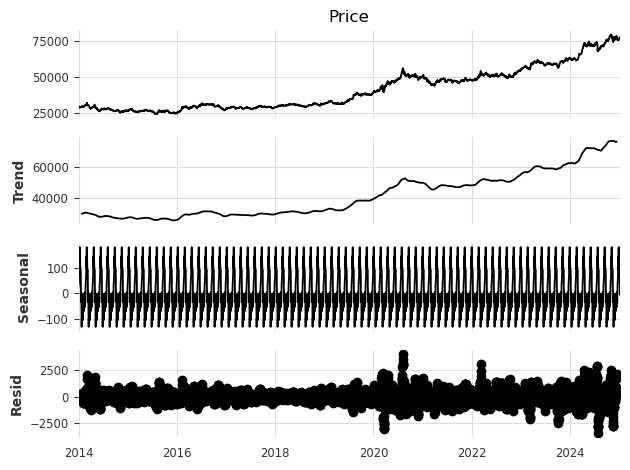

In [93]:
decompose_plot_additive = seasonal_decompose(gold_price.Price, model='additive', period=52)
decompose_plot_additive.plot()
plt.show()

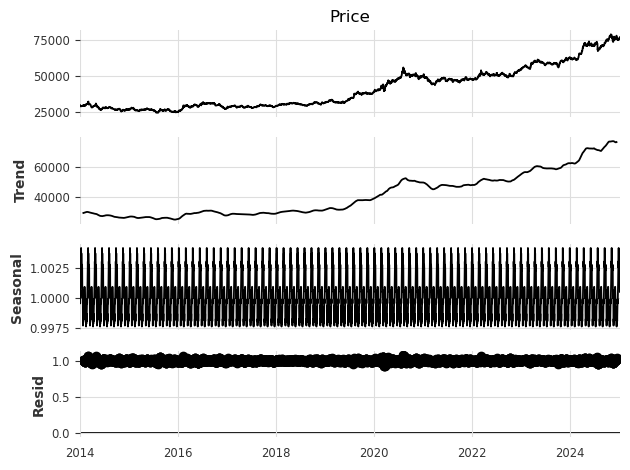

In [94]:
decompose_plot_multiplicative = seasonal_decompose(gold_price.Price, model='multiplicative', period=52)
decompose_plot_multiplicative.plot()
plt.show()

We can see that is multiplicative by the residuals, in the additive models they grow up with the time.

So, we will have to apply `log` to our serie in a future.

### Feature Engineering

In [95]:
import holidays

In [96]:
start_year = gold_price.index.min().year
end_year = gold_price.index.max().year

us_holidays = holidays.UnitedStates(years=range(start_year, end_year + 1))
uk_holidays = holidays.UnitedKingdom(years=range(start_year, end_year + 1))

combined = set(us_holidays.keys()) | set(uk_holidays.keys())

idx_dates = gold_price.index.normalize().date
gold_price["is_holiday"] = [1 if d in combined else 0 for d in idx_dates]

holiday_list = sorted(list(combined))

def days_to_next(date_val: pd.Timestamp) -> int:
    for h in holiday_list:
        if h >= date_val:
            return (h - date_val).days
    return np.nan
    
gold_price['days_to_next_holiday'] = [days_to_next(d) for d in idx_dates]

gold_price.loc[:, "is_weekend"] = (gold_price.index.weekday >= 5).astype(int)

gold_price.head(10)

,Price,is_holiday,days_to_next_holiday,is_weekend
2014-01-01,29542.0,1,0,0
2014-01-02,29975.0,0,18,0
2014-01-03,29727.0,0,17,0
2014-01-04,29279.0,0,16,1
2014-01-05,29279.0,0,15,1
2014-01-06,29119.0,0,14,0
2014-01-07,28959.0,0,13,0
2014-01-08,28934.0,0,12,0
2014-01-09,28997.0,0,11,0
2014-01-10,29169.0,0,10,0


In [97]:
gold_price.index.min(), gold_price.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

### Create train and test sets for time series

In [98]:
timesteps = gold_price.index.to_numpy()
price = gold_price.Price.to_numpy()

In [99]:
# Create train and test splits, 80% train, 20% test
# split_size = int(0.8 * len(price))
split_size = -37

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:2*split_size], price[:2*split_size]

# Create validation data splits (everything before the split)
X_val, y_val = timesteps[2*split_size:split_size], price[2*split_size:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], price[split_size:]

X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

len(X_train), len(y_train), len(X_test), len(y_test)

(3950, 3950, 37, 37)

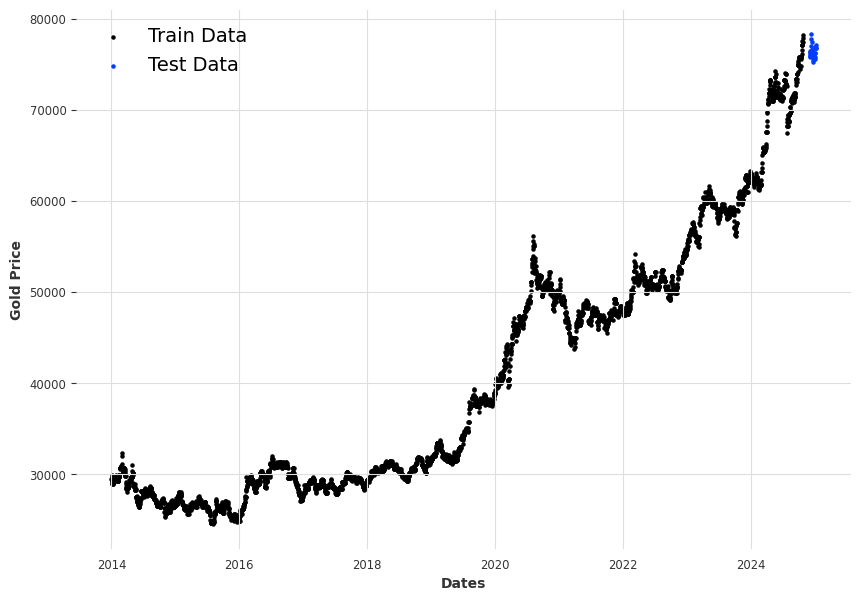

In [100]:
# Plot with train and test
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train Data')
plt.scatter(X_test, y_test, s=5, label='Test Data')
plt.xlabel('Dates')
plt.ylabel('Gold Price')
plt.legend(fontsize=14)
plt.show()

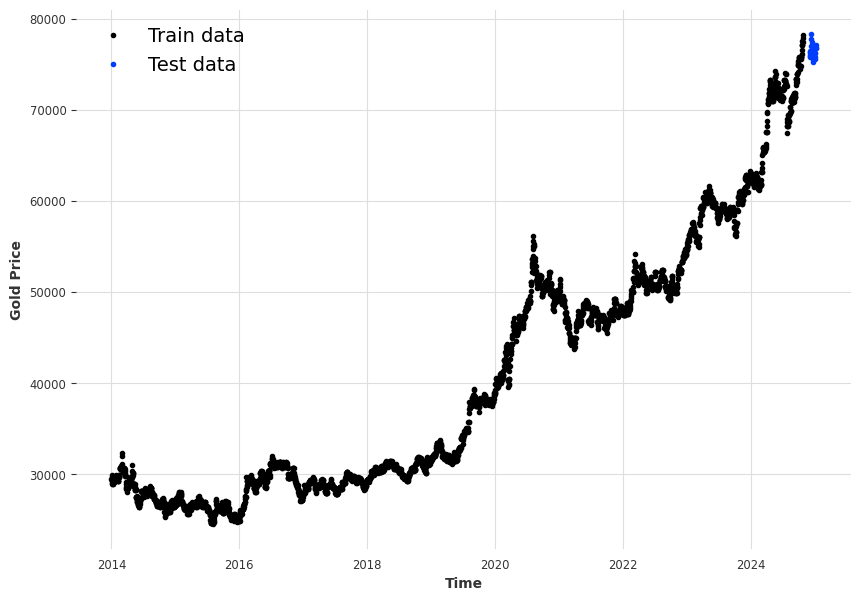

In [101]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data", xlabel='Time', ylabel='Gold Price')
plot_time_series(timesteps=X_test, values=y_test, label="Test data", xlabel='Time', ylabel='Gold Price')

## Baselines Models

### Baseline 0: Naive Forecast

$$\hat{y}_{t+1} = y_t$$

In [102]:
# Create a naive forecast
naive_preds = y_test[:-1]
naive_preds[:5]

array([76485., 75815., 75934., 76036., 76353.])

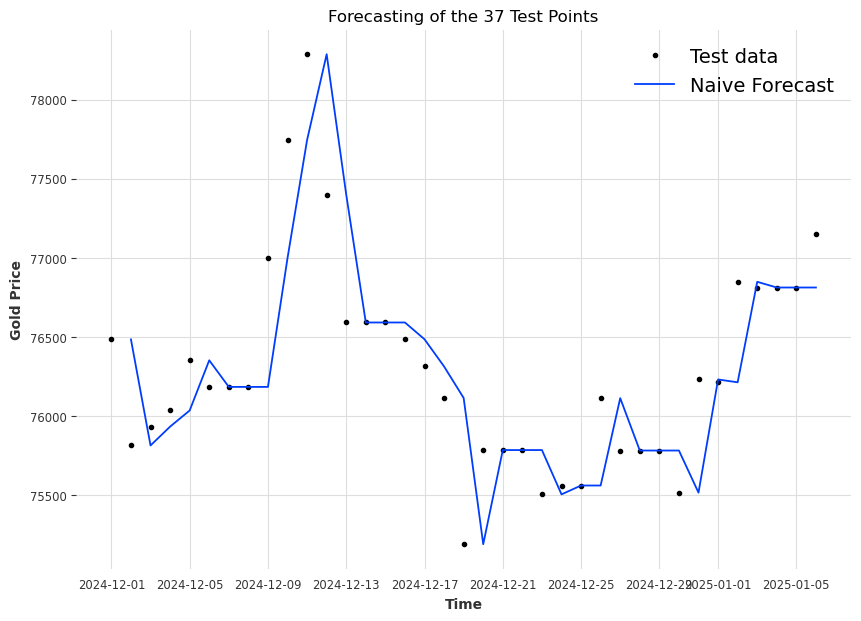

In [103]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test[1:], values=naive_preds, format='-', label='Naive Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Points')
plt.show()

In [104]:
naive_metrics = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_preds)
naive_metrics

{'mae': np.float32(288.72223),
 'mse': np.float32(178845.33),
 'rmse': np.float32(422.9011),
 'mape': np.float32(0.3774737)}

### Baseline 1: ARIMA

Bibliography: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

* **AR (Autoregression):** This emphasizes the dependent relationship between an observation and its preceding or 'lagged' observations.
* **I (Integrated):** To achieve a stationary time series, one that doesn't exhibit trend or seasonality, differencing is applied. It typically involves subtracting an observation from its preceding observation.
* **MA (Moving Average):** This component zeroes in on the relationship between an observation and the residual error from a moving average model based on lagged observations.

In [105]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot

#### Stationarity

We first need to apply logarithms to the serie, because we saw that it was a multiplicative model.

In [106]:
log_gold_price = np.log(gold_price.Price)
log_gold_price.head()

2014-01-01    10.293568
2014-01-02    10.308119
2014-01-03    10.299811
2014-01-04    10.284626
2014-01-05    10.284626
Freq: D, Name: Price, dtype: float64

In [107]:
# Check for stationarity (mean and variance constant)
adf = adfuller(log_gold_price)
print(f'ADF p-value: {adf[1]}')

ADF p-value: 0.9911734545221276


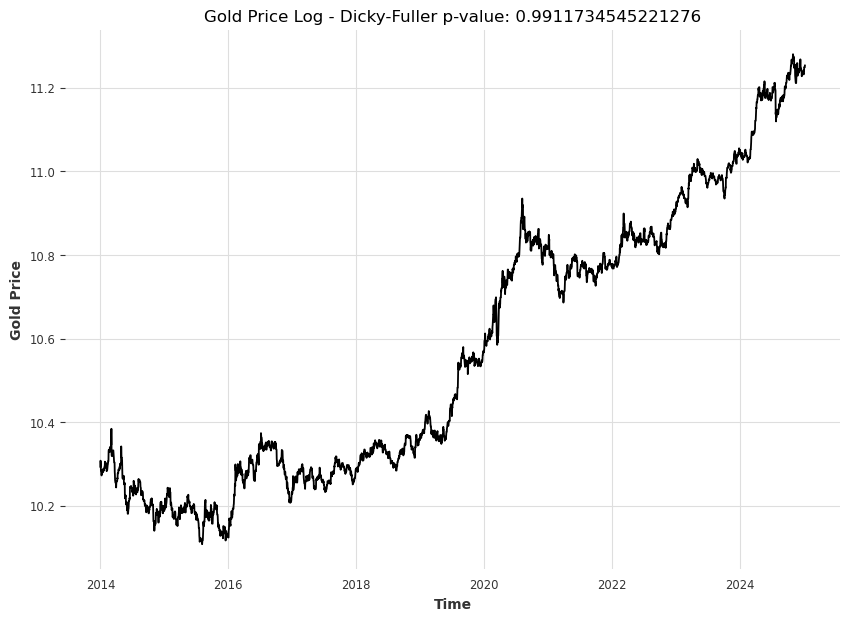

In [108]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=log_gold_price.index,
                 values=log_gold_price.values,
                 format='-',
                 xlabel='Time',
                 ylabel='Gold Price')
plt.title(f'Gold Price Log - Dicky-Fuller p-value: {adf[1]}')
plt.show()

In [109]:
# We have to differentiate, because the p-value was greater than 0.05
log_gold_price_stationarity = log_gold_price.diff().dropna()
adf_diff = adfuller(log_gold_price_stationarity)
print(f'ADF p-value with 1 differentation: {adf_diff[1]}')

ADF p-value with 1 differentation: 2.8469869896195193e-30


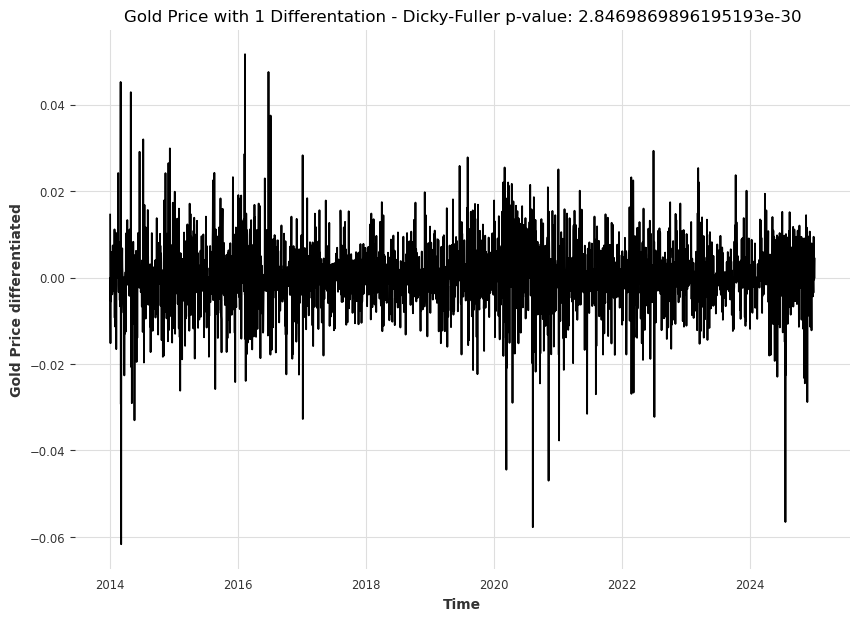

In [110]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=log_gold_price_stationarity.index,
                 values=log_gold_price_stationarity.values,
                 format='-',
                 xlabel='Time',
                 ylabel='Gold Price differentiated')
plt.title(f'Gold Price with 1 Differentation - Dicky-Fuller p-value: {adf_diff[1]}')
plt.show()

#### ACF and PACF

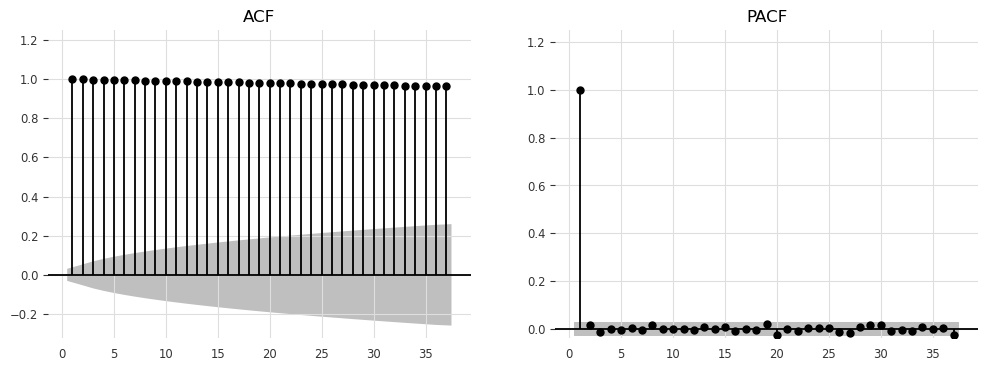

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(gold_price.Price, ax=axes[0], zero=False, auto_ylims=True, title='ACF')
plot_pacf(gold_price.Price, ax=axes[1], zero=False, auto_ylims=True, title='PACF')
plt.show()

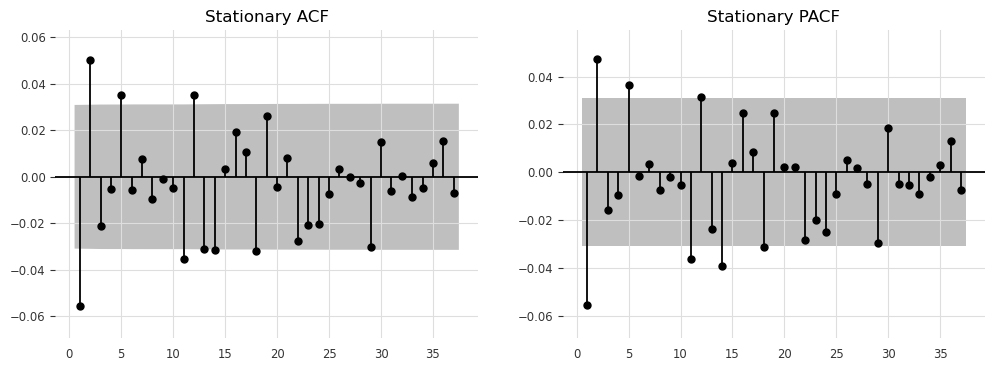

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(log_gold_price_stationarity, ax=axes[0], zero=False, auto_ylims=True, title='Stationary ACF')
plot_pacf(log_gold_price_stationarity, ax=axes[1], zero=False, auto_ylims=True, title='Stationary PACF')
plt.show()

We can try the next models:

* `ARIMA(0, 1, 0)` - **Random Walk**
* `ARIMA(1, 1, 0)`
* `ARIMA(1, 1, 1)`
* `ARIMA(1, 1, 2)`

#### Create Model

In [113]:
log_gold_price_train = pd.Series(np.log(y_train), index=pd.DatetimeIndex(X_train, freq='D'))
log_gold_price_val = pd.Series(np.log(y_val), index=pd.DatetimeIndex(X_val, freq='D'))
log_gold_price_train_val = pd.Series(np.log(y_train_val), index=pd.DatetimeIndex(X_train_val, freq='D'))
log_gold_price_test = pd.Series(np.log(y_test), index=pd.DatetimeIndex(X_test, freq='D'))

In [114]:
model_arima_010 = ARIMA(log_gold_price_train_val, order=(0, 1, 0))
model_arima_110 = ARIMA(log_gold_price_train_val, order=(1, 1, 0))
model_arima_111 = ARIMA(log_gold_price_train_val, order=(1, 1, 1))
model_arima_112 = ARIMA(log_gold_price_train_val, order=(1, 1, 2))
model_arima_212 = ARIMA(log_gold_price_train_val, order=(2, 1, 2))

results_arima_010 = model_arima_010.fit()
results_arima_110 = model_arima_110.fit()
results_arima_111 = model_arima_111.fit()
results_arima_112 = model_arima_112.fit()
results_arima_212 = model_arima_212.fit()

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [115]:
results_arima_010.aic, results_arima_110.aic, results_arima_111.aic, results_arima_112.aic, results_arima_212.aic

(np.float64(-28236.047379327923),
 np.float64(-28246.130913028406),
 np.float64(-28248.629395350847),
 np.float64(-28251.841382477345),
 np.float64(-28252.313029657074))

The best ARIMA model looking at the AIC metric is: `ARIMA(1, 1, 2)`.

#### Make Predictions

Now, we will make the predictions using the **walk-forward** technique.

In [116]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [117]:
history = list(log_gold_price_train_val)
arima_preds = []
for obs in log_gold_price_test:
    model = ARIMA(history, order=(1, 1, 2))
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        results = model.fit()
    log_pred = results.forecast()[0]
    arima_preds.append(np.exp(log_pred))
    history.append(obs) # take in the real observation

#### Evaluate Predicts

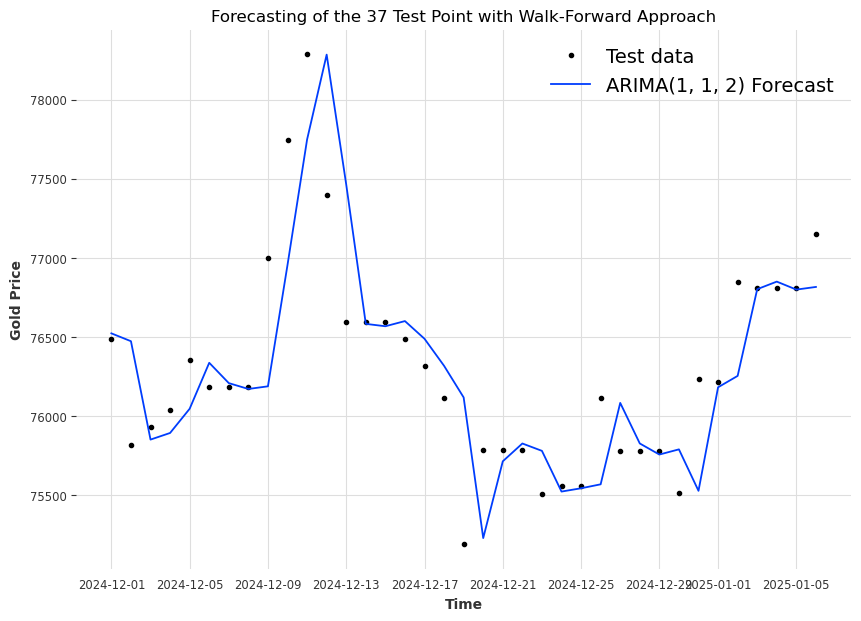

In [118]:
# Plot ARIMA(1, 1, 2) forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=arima_preds, format='-', label='ARIMA(1, 1, 2) Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Point with Walk-Forward Approach')
plt.show()

In [119]:
arima_metrics = evaluate_preds(y_true=y_test,
                               y_pred=arima_preds)
arima_metrics

{'mae': np.float32(288.50107),
 'mse': np.float32(174503.95),
 'rmse': np.float32(417.7367),
 'mape': np.float32(0.3772017)}

In [120]:
log_pred_arima_direct = results_arima_112.get_forecast(steps=37)
pred_arima_direct = np.exp(log_pred_arima_direct.predicted_mean).values
arima_direct_metrics = evaluate_preds(y_true=y_test, y_pred=pred_arima_direct)
arima_direct_metrics

{'mae': np.float32(557.6049),
 'mse': np.float32(464161.5),
 'rmse': np.float32(681.294),
 'mape': np.float32(0.7308145)}

### Baseline 2: SARIMAX

Our TS is anual stational, so we would need to look at the lags 365, 730 and so on, if we want to know the parameters P and Q of the model ``SARIMAX(p, d, q)x(P, D, Q, m)``. Therefore, we will use grid search to compute the best parameters. We will try the next models:

* ``SARIMAX(0, 1, 0)x(0, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(2, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 2, 365)``
* ``SARIMAX(1, 1, 0)x(2, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 2, 365)``

In [121]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Exogenus variables

First of all, we have to load, clean, transform and put all the exogenus variables into the `gold_price` dataframe.

In [122]:
from utils.load import load_csv_into_dates, load_csv_and_glue_time_series

In [123]:
folder_exogenus_gold_variables = os.path.join(os.getcwd(), '..', 'data', 'exogenus_gold')

##### BRENT

In [124]:
brent = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'brent', 'brent-daily.csv'))
brent.index.min(), brent.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

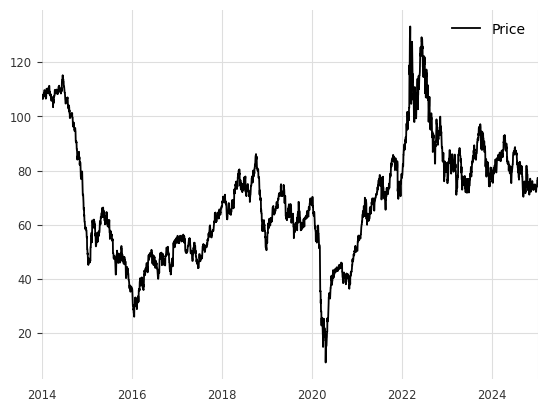

In [125]:
brent.plot()

##### WTI

In [126]:
wti = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'wti', 'wti-daily.csv'))
wti.index.min(), wti.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

In [127]:
wti[wti.values < 0]

,Price
2020-04-18,-36.98
2020-04-19,-36.98
2020-04-20,-36.98


<Axes: >

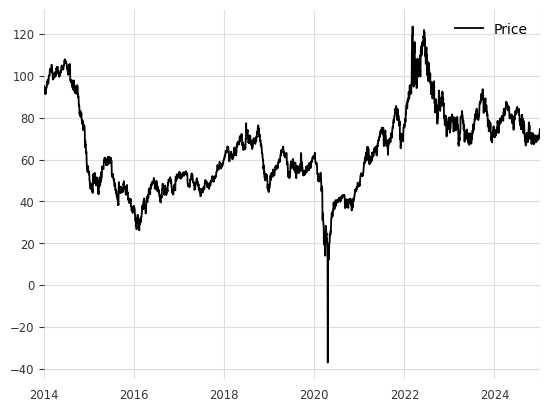

In [128]:
wti.plot()

##### DXY - Dollar Index

In [129]:
folder_dxy = os.path.join(folder_exogenus_gold_variables, 'DXY')
dxy = load_csv_and_glue_time_series(folder_path=folder_dxy, column_name='Open')
dxy.index.min(), dxy.index.max()

c:\Users\Usuario\Documents\Time_Series_Comparision_Models\analysis\..\utils\load.py:13: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

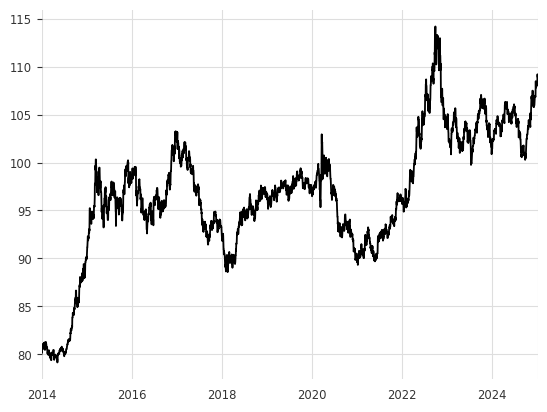

In [130]:
dxy.plot()

##### EURUSD

In [131]:
eurusd = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'EURUSD', 'EURUSD_D1.csv'), header=None)
eurusd = eurusd.iloc[:, 0]
eurusd.index.min(), eurusd.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

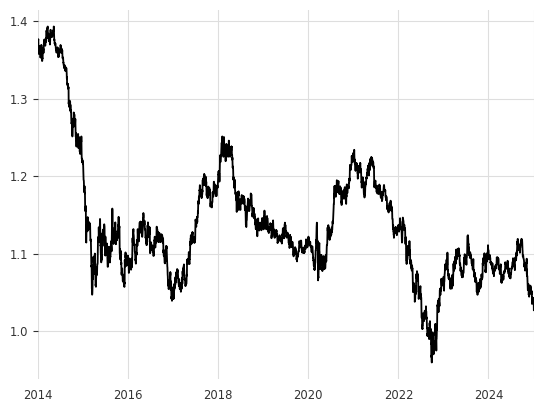

In [132]:
eurusd.plot()

##### VIX

In [133]:
vix = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'VIX', 'VIX_history.csv'),
                          column_name='OPEN')
vix.index.min(), vix.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

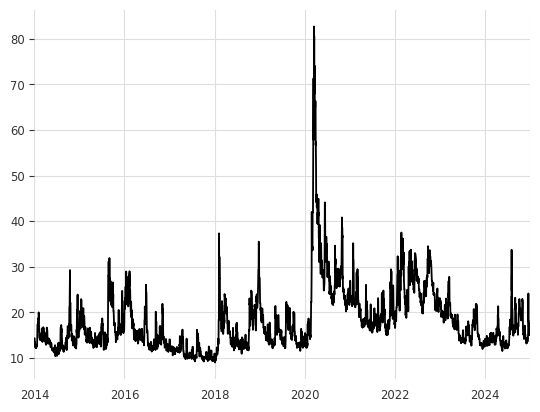

In [134]:
vix.plot()

##### S&P 500

In [135]:
sp500 = load_csv_and_glue_time_series(folder_path=os.path.join(folder_exogenus_gold_variables, 'SP500'),
                                      column_name='Open')
sp500.index.min(), sp500.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

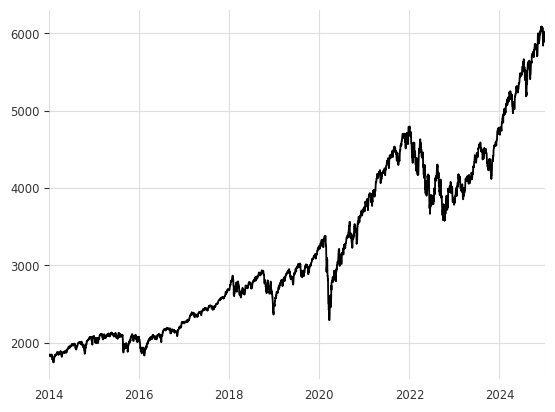

In [136]:
sp500.plot()

##### T5YIE

In [137]:
t5yie = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'T5YIE', 'T5YIE.csv'),
                            column_name='Open')
fecha_01_01_2014 = t5yie.index[0] - pd.Timedelta(days=1)
valor_01_01_2014 = t5yie.iloc[0]
t5yie = pd.concat([
    pd.Series([valor_01_01_2014], index=[fecha_01_01_2014]),
    t5yie
])
t5yie.index.min(), t5yie.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

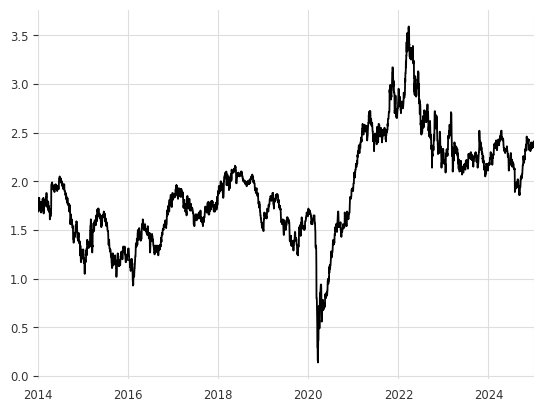

In [138]:
t5yie.plot()

##### T10YIE

In [139]:
t10yie = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'T10YIE', 'T10YIE.csv'),
                            column_name='Open')
fecha_01_01_2014 = t10yie.index[0] - pd.Timedelta(days=1)
valor_01_01_2014 = t10yie.iloc[0]
t10yie = pd.concat([
    pd.Series([valor_01_01_2014], index=[fecha_01_01_2014]),
    t10yie
])
t10yie.index.min(), t10yie.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

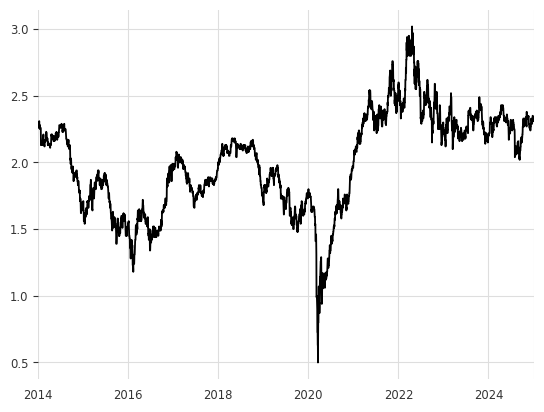

In [140]:
t10yie.plot()

#### Preparing data with Exogenus Variables

In [141]:
gold_price['brent'] = brent
gold_price['wti'] = wti
gold_price['dxy'] = dxy
gold_price['vix'] = vix
gold_price['eurusd'] = eurusd
gold_price['sp500'] = sp500
gold_price['t5yie'] = t5yie
gold_price.head()

,Price,is_holiday,days_to_next_holiday,is_weekend,brent,wti,dxy,vix,eurusd,sp500,t5yie
2014-01-01,29542.0,1,0,0,107.94,95.14,80.21,14.32,1.37553,1845.859985,1.71
2014-01-02,29975.0,0,18,0,107.94,95.14,80.12,14.32,1.37653,1845.859985,1.71
2014-01-03,29727.0,0,17,0,106.57,93.66,80.57,14.06,1.36653,1833.209961,1.69
2014-01-04,29279.0,0,16,1,106.71,93.12,80.86,13.41,1.35935,1832.310059,1.75
2014-01-05,29279.0,0,15,1,106.71,93.12,80.86,13.41,1.35935,1832.310059,1.75


We need to separate our exogenus variables from our raw gold_price dataframe. Furthermore, we will need also to split in train and test this new dataset.

In [142]:
exog_data = gold_price.reset_index().drop(columns=['index', 'Price'])
exog_data.head()

,is_holiday,days_to_next_holiday,is_weekend,brent,wti,dxy,vix,eurusd,sp500,t5yie
0,1,0,0,107.94,95.14,80.21,14.32,1.37553,1845.859985,1.71
1,0,18,0,107.94,95.14,80.12,14.32,1.37653,1845.859985,1.71
2,0,17,0,106.57,93.66,80.57,14.06,1.36653,1833.209961,1.69
3,0,16,1,106.71,93.12,80.86,13.41,1.35935,1832.310059,1.75
4,0,15,1,106.71,93.12,80.86,13.41,1.35935,1832.310059,1.75


In [143]:
exog_train = exog_data.iloc[:2*split_size, :]
exog_val = exog_data.iloc[2*split_size:split_size, :]
exog_train_val = pd.concat([exog_train, exog_val])
exog_test = exog_data.iloc[split_size:, :]

exog_train.shape, exog_val.shape, exog_train_val.shape, exog_test.shape

((3950, 10), (37, 10), (3987, 10), (37, 10))

We also need to transform our 'anual seasonality' in terms of **Fourier** for agilize the computation, and get rid of the seasonality in SARIMAX.

In [144]:
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import auto_arima

In [145]:
fourier_gen = FourierFeaturizer(m=365.25, k=4)
log_gold_price_fourier, exog_data_fourier = fourier_gen.fit_transform(log_gold_price.values, exog_data)

exog_train_fourier = exog_data_fourier.iloc[:2*split_size, :]
exog_val_fourier = exog_data_fourier.iloc[2*split_size:split_size, :]
exog_train_val_fourier = pd.concat([exog_train_fourier, exog_val_fourier])
exog_test_fourier = exog_data_fourier.iloc[split_size:, :]

exog_train_fourier.shape, exog_val_fourier.shape, exog_train_val_fourier.shape, exog_test_fourier.shape

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



((3950, 18), (37, 18), (3987, 18), (37, 18))

#### Create Model

In [146]:
# Exogenus without Fourier and without seasonality

model_sarimax_010_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_110_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_111_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_sarimax_112_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(1, 1, 2), seasonal_order=(0, 0, 0, 0))
model_sarimax_212_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))

results_sarimax_010_000_365 = model_sarimax_010_000_365.fit()
results_sarimax_110_000_365 = model_sarimax_110_000_365.fit()
results_sarimax_111_000_365 = model_sarimax_111_000_365.fit()
results_sarimax_112_000_365 = model_sarimax_112_000_365.fit()
results_sarimax_212_000_365 = model_sarimax_212_000_365.fit()

results_sarimax_010_000_365.aic, results_sarimax_110_000_365.aic, results_sarimax_111_000_365.aic, results_sarimax_112_000_365.aic, results_sarimax_212_000_365.aic

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



(np.float64(-28258.81917047356),
 np.float64(-28276.985655355966),
 np.float64(-28278.526195146987),
 np.float64(-28279.888343391303),
 np.float64(-5931.6033544619695))

In [147]:
# Exogenus without Fourier, but with seasonality

with warnings.catch_warnings():
    
    warnings.simplefilter("ignore", category=FutureWarning)
    model_sarimax_auto = auto_arima(
        y=log_gold_price_train_val,
        exogenus=exog_train_val,
        seasonal=True,
        m=52,
        stepwise=True,
        suppress_warnings=True,
        trace=False
    )

model_sarimax_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3987
Model:               SARIMAX(2, 1, 2)   Log Likelihood               14133.488
Date:               sá., 20 sep. 2025   AIC                         -28254.976
Time:                        12:06:15   BIC                         -28217.233
Sample:                    01-01-2014   HQIC                        -28241.595
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      2.195      0.028    7.23e-05       0.001
ar.L1         -1.1518      0.150     -7.691      0.000      -1.445      -0.858
ar.L2         -0.6531      0.107     -6.084      0.000      -0.864      -0.443
ma.L1          1.0986      0.147      7.449      0.000       0.810       1.388
ma.L2          0.6448      0.101      6.381      0.000       0.447       0.843
sigma2      4.869e-05   4.95e-07     98.278      0.000    4.77e-05    4.97e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13091.05
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
# Exogenus with Fourier

model_sarimax_010_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_110_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_111_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_sarimax_112_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(1, 1, 2), seasonal_order=(0, 0, 0, 0))
model_sarimax_212_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))

results_sarimax_010_000_fourier = model_sarimax_010_000_fourier.fit()
results_sarimax_110_000_fourier = model_sarimax_110_000_fourier.fit()
results_sarimax_111_000_fourier = model_sarimax_111_000_fourier.fit()
results_sarimax_112_000_fourier = model_sarimax_112_000_fourier.fit()
results_sarimax_212_000_fourier = model_sarimax_212_000_fourier.fit()

results_sarimax_010_000_fourier.aic, results_sarimax_110_000_fourier.aic, results_sarimax_111_000_fourier.aic, results_sarimax_112_000_fourier.aic, results_sarimax_212_000_fourier.aic

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(np.float64(-28252.679195734185),
 np.float64(-28271.461850238567),
 np.float64(-28272.642984480557),
 np.float64(-28273.127557563363),
 np.float64(-28102.970070546908))

The model with lowest AIC is `SARIMAX(1, 1, 2)x(0, 0, 0, 0)` without seasonality nor Fourier's features.

#### Make Predictions

In [149]:
history = list(log_gold_price_train_val.values)
sarimax_preds = []

for i in range(len(log_gold_price_test)):

    model = SARIMAX(
        endog=history,
        exog=exog_data.iloc[:len(history)],
        order=(1, 1, 2),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        results = model.fit(disp=False)

    log_pred = results.forecast(steps=1, exog=exog_test.iloc[i:i+1])
    sarimax_preds.append(np.exp(log_pred))

    history.append(log_gold_price_test.values[i])

#### Evaluate Predicts

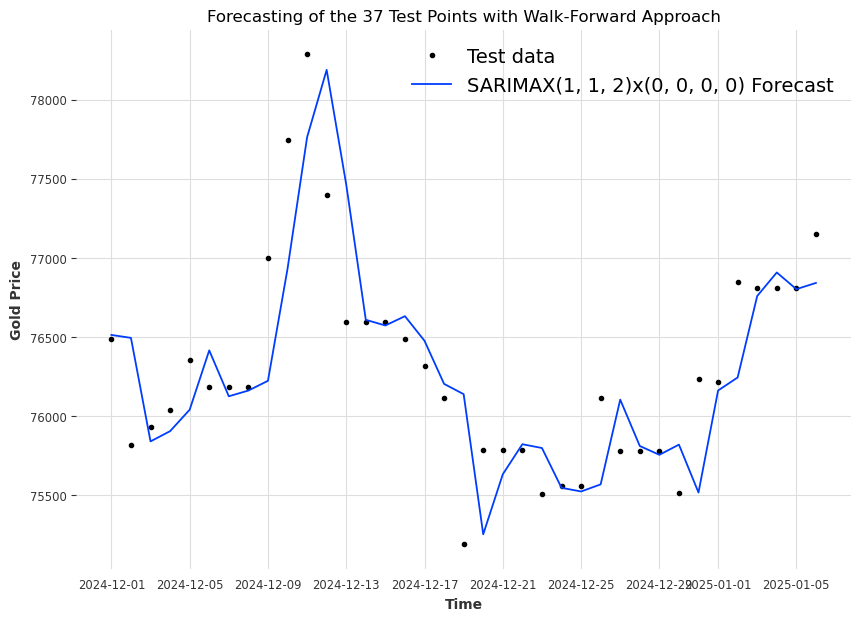

In [150]:
# Plot SARIMAX(1, 1, 2) forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=sarimax_preds, format='-', label='SARIMAX(1, 1, 2)x(0, 0, 0, 0) Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Points with Walk-Forward Approach')
plt.show()

In [151]:
sarimax_metrics = evaluate_preds(y_true=y_test,
                                 y_pred=sarimax_preds)
sarimax_metrics

{'mae': np.float32(697.0188),
 'mse': np.float32(818114.1),
 'rmse': np.float32(904.49664),
 'mape': np.float32(0.9114891)}

In [152]:
log_pred_sarimax_direct = results_sarimax_112_000_365.get_forecast(steps=37, exog=exog_test)
pred_sarimax_direct = np.exp(log_pred_sarimax_direct.predicted_mean).values
sarimax_direct_metrics = evaluate_preds(y_true=y_test, y_pred=pred_sarimax_direct)
sarimax_direct_metrics

{'mae': np.float32(518.5511),
 'mse': np.float32(401148.6),
 'rmse': np.float32(633.3629),
 'mape': np.float32(0.67884296)}

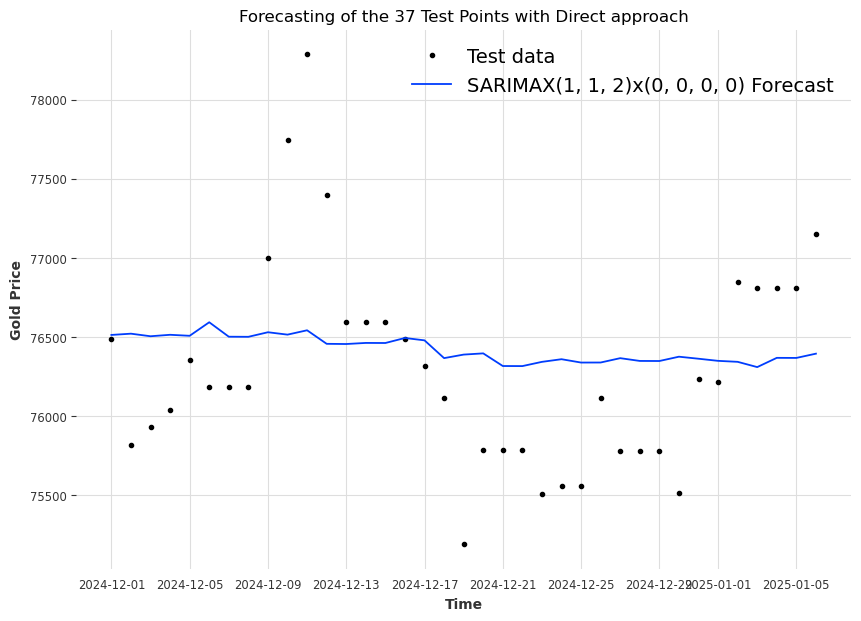

In [153]:
# Plot SARIMAX(1, 1, 2) forecast direct
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=pred_sarimax_direct, format='-', label='SARIMAX(1, 1, 2)x(0, 0, 0, 0) Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Points with Direct approach')
plt.show()

### Final Results for Baseline Models

| Metrics / Baselines | Naive | ARIMA | SARIMAX |
|----------------|-----------|-----------|-----------|
| MAE  | 288.35  | 288.72  | 697.02  |
| MSE  | 174403.08  | 178845.33  | 818114.06  |
| RMSE  | 422.90  | 417.62  | 861.11  |
| MAPE  | 0.38  | 0.38  | 0.91  |


## Main Models

### Make Windows

First of all, we need to transform our Forecasting Time Series problem in a Supervised Prediction problem. So, the technique that we are going to use is make windows (we will try differnt window's sizes), and use this windows like a features where our model is trained on, and the last element will be the `y` that we are trying to predict.

In [154]:
from utils.windows import make_windows

In [155]:
WINDOW_SIZE = 30
HORIZON = 1

We have to include the exogenus variables into the window-format.

In [156]:
index = pd.date_range(start='2014-01-01', periods=len(gold_price)-1, freq='D')[WINDOW_SIZE-1:]
first_iter = True
for var in gold_price.columns.values:
    columns_var = [f'{var}_{i+1}' for i in range(WINDOW_SIZE)]
    if var == 'Price':
        full_windows, full_labels = make_windows(gold_price[var], window_size=WINDOW_SIZE, horizon=HORIZON)
    else:
        full_windows, _ = make_windows(gold_price[var], window_size=WINDOW_SIZE, horizon=HORIZON)
    if first_iter:
        df = pd.DataFrame(full_windows, columns=columns_var, index=index)
        first_iter = False
        continue
    df2 = pd.DataFrame(full_windows, columns=columns_var, index=index)
    df = pd.concat([df, df2], axis=1)

In [157]:
gold_price_windowed = df.copy()
gold_price_windowed.head()

,Price_1,Price_2,Price_3,Price_4,Price_5,Price_6,Price_7,Price_8,Price_9,Price_10,...,t5yie_21,t5yie_22,t5yie_23,t5yie_24,t5yie_25,t5yie_26,t5yie_27,t5yie_28,t5yie_29,t5yie_30
2014-01-30,29542.0,29975.0,29727.0,29279.0,29279.0,29119.0,28959.0,28934.0,28997.0,29169.0,...,1.71,1.79,1.72,1.68,1.72,1.72,1.72,1.71,1.72,1.76
2014-01-31,29975.0,29727.0,29279.0,29279.0,29119.0,28959.0,28934.0,28997.0,29169.0,29169.0,...,1.79,1.72,1.68,1.72,1.72,1.72,1.71,1.72,1.76,1.72
2014-02-01,29727.0,29279.0,29279.0,29119.0,28959.0,28934.0,28997.0,29169.0,29169.0,29169.0,...,1.72,1.68,1.72,1.72,1.72,1.71,1.72,1.76,1.72,1.70
2014-02-02,29279.0,29279.0,29119.0,28959.0,28934.0,28997.0,29169.0,29169.0,29169.0,29312.0,...,1.68,1.72,1.72,1.72,1.71,1.72,1.76,1.72,1.70,1.70
2014-02-03,29279.0,29119.0,28959.0,28934.0,28997.0,29169.0,29169.0,29169.0,29312.0,29198.0,...,1.72,1.72,1.72,1.71,1.72,1.76,1.72,1.70,1.70,1.70


Before continuing, we have to remove all calendar variables from 1 to 29, and only stay with the 30th.

In [158]:
calendar_vars = ["is_weekend", "is_holiday", "days_to_next_holiday"]
keep_cols = []
for var in calendar_vars:
    keep_cols.append(f"{var}_{WINDOW_SIZE}")

for col in gold_price_windowed.columns:
    if not any(col.startswith(var) for var in calendar_vars):
        keep_cols.append(col)

gold_price_windowed = gold_price_windowed[keep_cols]
len(gold_price_windowed.columns.values)

243

In [159]:
# Turning windows into training and tests sets
train_gold_price_windowed = gold_price_windowed[:2*split_size]
val_gold_price_windowed = gold_price_windowed[2*split_size:split_size]
test_gold_price_windowed = gold_price_windowed[split_size:]

train_labels = full_labels[:2*split_size]
val_labels = full_labels[2*split_size:split_size]
test_labels = full_labels[split_size:]

len(train_gold_price_windowed), len(val_gold_price_windowed), len(test_gold_price_windowed), len(train_labels), len(val_labels), len(test_labels)

(3920, 37, 37, 3920, 37, 37)

### LightGBM

In [160]:
import lightgbm as lgb

#### Create model

In [161]:
model_lightgbm = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=4,
    max_depth=2,
    min_split_gain=0.2,
    min_child_weight=100,
    min_child_samples=400,
    subsample=0.6,
    colsample_bytree=0.6,
    feature_fraction=0.6,
    reg_lambda=20.0,
    reg_alpha=5.0,
    random_state=42,
    verbose=-1
)

evals_result_lightgbm = {}

model_lightgbm.fit(train_gold_price_windowed, train_labels,
                   eval_set=[(val_gold_price_windowed, val_labels)],
                   eval_metric='rmse',
                   callbacks=[
                       lgb.early_stopping(stopping_rounds=80),
                       lgb.reset_parameter(learning_rate=lambda iter: 0.03 * (0.98 ** iter)),
                       lgb.log_evaluation(period=50),
                       lgb.record_evaluation(eval_result=evals_result_lightgbm)
                    ]
                )

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



Training until validation scores don't improve for 80 rounds
[50]	valid_0's rmse: 20665.1	valid_0's l2: 4.27045e+08
[100]	valid_0's rmse: 17503	valid_0's l2: 3.06355e+08
[150]	valid_0's rmse: 16573.2	valid_0's l2: 2.74672e+08
[200]	valid_0's rmse: 16261.9	valid_0's l2: 2.64451e+08
[250]	valid_0's rmse: 16155.6	valid_0's l2: 2.61003e+08
[300]	valid_0's rmse: 16118.4	valid_0's l2: 2.59803e+08
[350]	valid_0's rmse: 16104.3	valid_0's l2: 2.59348e+08
[400]	valid_0's rmse: 16099.3	valid_0's l2: 2.59186e+08
[450]	valid_0's rmse: 16097.5	valid_0's l2: 2.59128e+08
[500]	valid_0's rmse: 16096.8	valid_0's l2: 2.59107e+08
[550]	valid_0's rmse: 16096.6	valid_0's l2: 2.59099e+08
[600]	valid_0's rmse: 16096.5	valid_0's l2: 2.59097e+08
[650]	valid_0's rmse: 16096.4	valid_0's l2: 2.59095e+08
[700]	valid_0's rmse: 16096.4	valid_0's l2: 2.59095e+08
[750]	valid_0's rmse: 16096.4	valid_0's l2: 2.59095e+08
[800]	valid_0's rmse: 16096.4	valid_0's l2: 2.59095e+08
[850]	valid_0's rmse: 16096.4	valid_0's l2: 2.

,boosting_type,'gbdt'
,num_leaves,4
,max_depth,2
,learning_rate,0.03
,n_estimators,3000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.2
,min_child_weight,100
,min_child_samples,400


#### Make predictions

In [162]:
pred_lightgbm = model_lightgbm.predict(val_gold_price_windowed, num_iteration=model_lightgbm.best_iteration_)
pred_train_lightgbm = model_lightgbm.predict(train_gold_price_windowed, num_iteration=model_lightgbm.best_iteration_)
len(pred_lightgbm), len(pred_train_lightgbm)

(37, 3920)

#### Evaluate predictions

In this model, and all the coming models, there is a possibility of overfitting, so, I will look also the metrics on the train set.

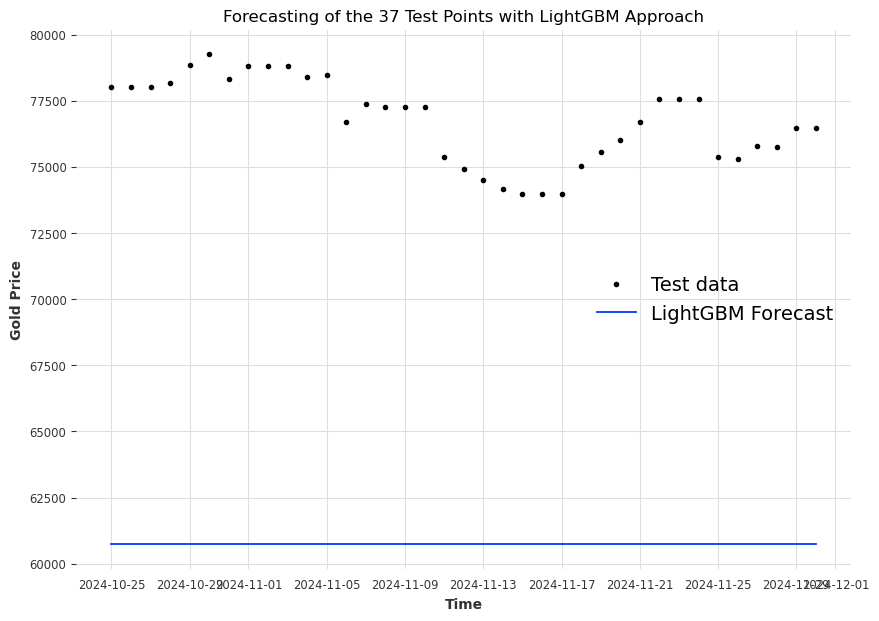

In [163]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=pred_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

In [164]:
lightgbm_metrics = evaluate_preds(y_true=y_val,
                                  y_pred=pred_lightgbm)
lightgbm_metrics

{'mae': np.float32(16018.044),
 'mse': np.float32(259094830.0),
 'rmse': np.float32(16096.423),
 'mape': np.float32(20.83523)}

#### Evaluate Overfitting

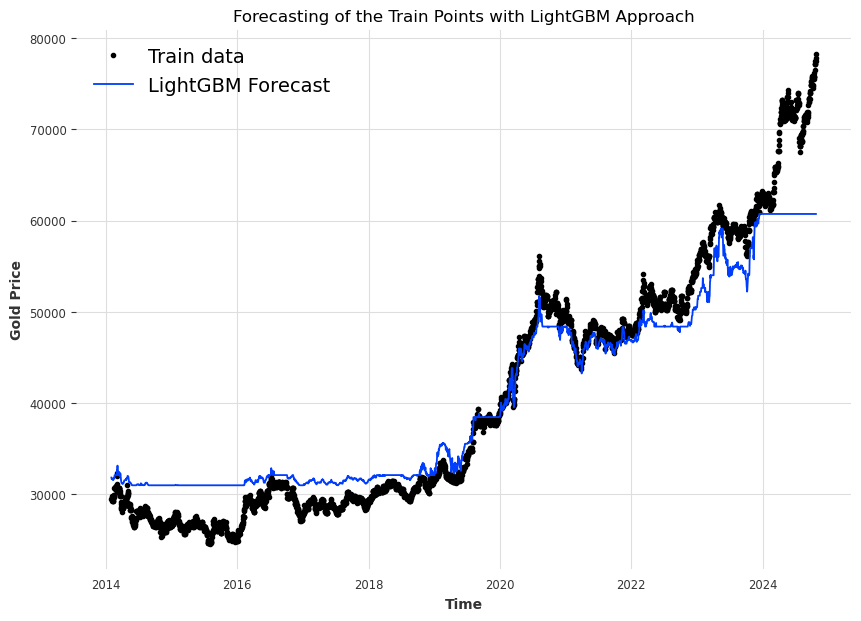

In [165]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=y_train[WINDOW_SIZE:], label="Train data")
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=pred_train_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the Train Points with LightGBM Approach')
plt.show()

In [166]:
lightgbm_metrics_train = evaluate_preds(y_true=y_train[WINDOW_SIZE:],
                                        y_pred=pred_train_lightgbm)
lightgbm_metrics_train

{'mae': np.float32(2867.1516),
 'mse': np.float32(14550571.0),
 'rmse': np.float32(3814.521),
 'mape': np.float32(7.434369)}

#### Final Model and Metrics

In [167]:
train_val_gold_price_windowed = pd.concat([train_gold_price_windowed, val_gold_price_windowed])
train_val_labels = np.concatenate((train_labels, val_labels))

In [168]:
model_lightgbm = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=31,
    min_split_gain=0,
    min_child_weight=0.1,
    min_child_samples=25,
    subsample_freq=1,
    reg_lambda=0,
    reg_alpha=0
)

model_lightgbm.fit(train_val_gold_price_windowed, train_val_labels,
                   eval_set=[(test_gold_price_windowed, test_labels)],
                   eval_metric='rmse')

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.01
,n_estimators,1000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0
,min_child_weight,0.1
,min_child_samples,25


In [169]:
pred_lightgbm = model_lightgbm.predict(test_gold_price_windowed)

In [170]:
lightgbm_metrics = evaluate_preds(y_true=y_test,
                                  y_pred=pred_lightgbm)
lightgbm_metrics

{'mae': np.float32(523.7086),
 'mse': np.float32(416087.94),
 'rmse': np.float32(645.04877),
 'mape': np.float32(0.6858997)}

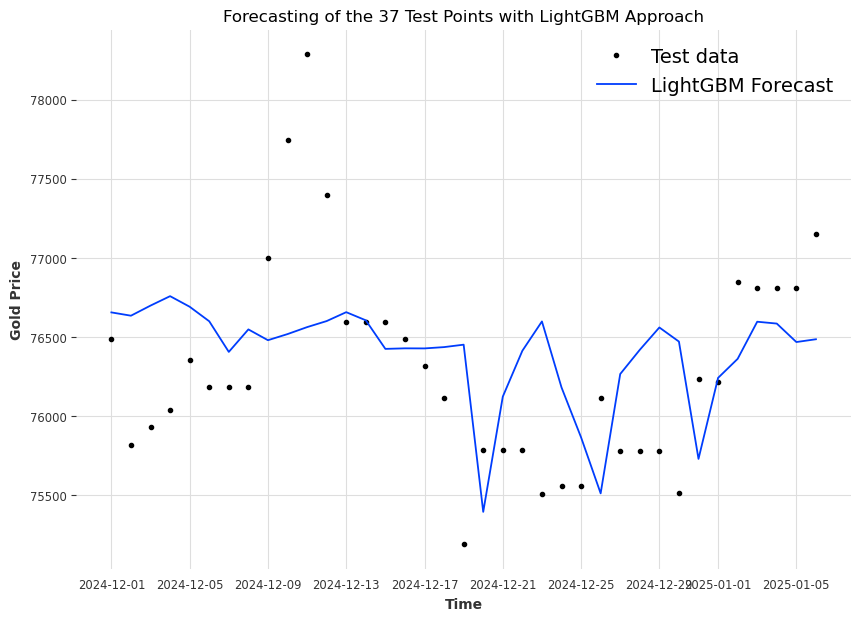

In [171]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=pred_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

### N-BEATS

In [172]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

from utils.preds import make_predictions_rolling_one_darts

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



#### Prepare the data for `darts`

We have to transform our `pd.DataFrame` into a `TimeSeries` object, and scale it.

In [173]:
# Create scalers for both
scaler = Scaler()

# Create TimeSeries objects to work with darts framework
gold_price_darts_train = TimeSeries.from_dataframe(gold_price[:split_size], value_cols='Price')
gold_price_darts_test = TimeSeries.from_dataframe(gold_price[split_size:], value_cols='Price')

# Scale the data
gold_price_darts_scaled_train = scaler.fit_transform(gold_price_darts_train)
gold_price_darts_scaled_test = scaler.transform(gold_price_darts_test)

#### Create model without exogenus variables

In [174]:
model_nbeats = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    n_epochs=10,
    random_state=42
)

model_nbeats.fit(gold_price_darts_scaled_train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
------------

Epoch 9: 100%|██████████| 124/124 [00:21<00:00,  5.83it/s, train_loss=0.000192]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 124/124 [00:21<00:00,  5.83it/s, train_loss=0.000192]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=10, random_state=42)

#### Make Predictions

In [175]:
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [176]:
preds_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                  ts_test=gold_price_darts_scaled_test,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


#### Evaluate Predicts

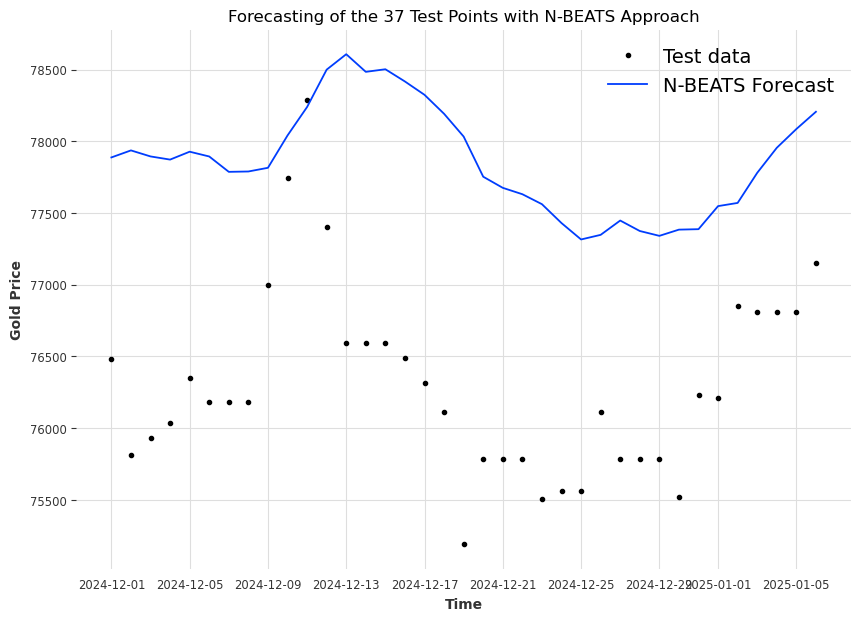

In [177]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=preds_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Points with N-BEATS Approach')
plt.show()

In [178]:
nbeats_metrics = evaluate_preds(y_true=y_test,
                                y_pred=preds_nbeats)
nbeats_metrics

{'mae': np.float32(1559.5767),
 'mse': np.float32(2720745.8),
 'rmse': np.float32(1649.4684),
 'mape': np.float32(2.0488362)}

#### Evaluate Overfitting

In [179]:
holdout_scaled_train = gold_price_darts_scaled_train.slice(
    gold_price_darts_train.time_index[2*split_size+1],
    gold_price_darts_train.time_index[split_size]
)
not_holdout_scaled_train = gold_price_darts_scaled_train.slice(
    gold_price_darts_train.time_index[0],
    gold_price_darts_train.time_index[2*split_size]
)

In [180]:
preds_holdout_train_nbeats = make_predictions_rolling_one_darts(ts_train=not_holdout_scaled_train,
                                                  ts_test=holdout_scaled_train,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.91it/s]


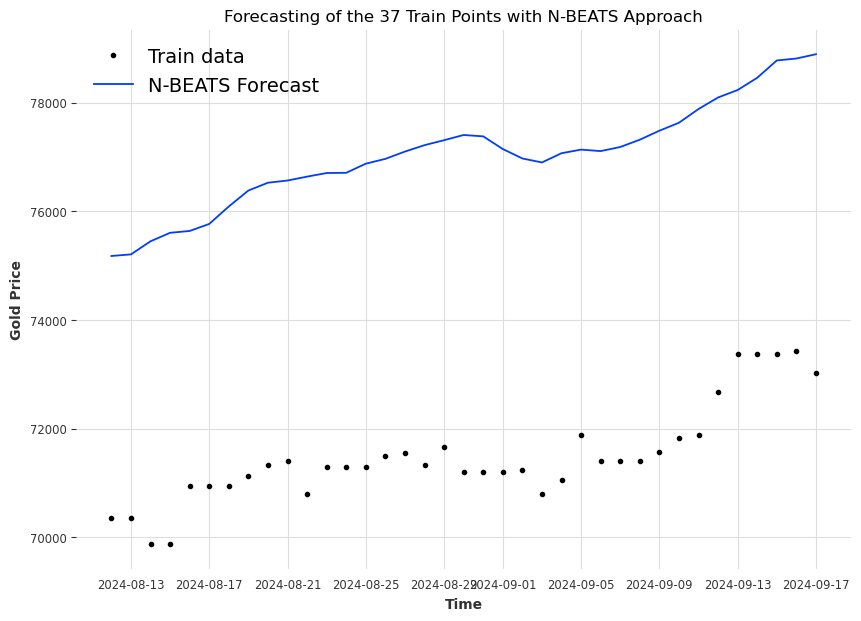

In [181]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[2*split_size:split_size], values=y_train[2*split_size:split_size], label="Train data", start=0, end=50)
plot_time_series(timesteps=X_train[2*split_size:split_size], values=preds_holdout_train_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Train Points with N-BEATS Approach')
plt.show()

In [182]:
nbeats_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeats,
                                      y_true=y_train[2*split_size:split_size])
nbeats_train_metrics

{'mae': np.float32(5533.3057),
 'mse': np.float32(30783962.0),
 'rmse': np.float32(5548.3296),
 'mape': np.float32(7.7415175)}

### LSTM - Long Short Term Memory

In [183]:
from darts.models import RNNModel

#### Preparing the data

In [184]:
# Create scaler
scaler_exogenus = Scaler()

gold_price_exogenus_darts_train = TimeSeries.from_dataframe(gold_price[:split_size], value_cols=exog_data.columns.values)
gold_price_exogenus_darts_test = TimeSeries.from_dataframe(gold_price[split_size:], value_cols=exog_data.columns.values)

gold_price_exogenus_darts_scaled_train = scaler_exogenus.fit_transform(gold_price_exogenus_darts_train)
gold_price_exogenus_darts_scaled_test = scaler_exogenus.transform(gold_price_exogenus_darts_test)

#### Create Model

In [185]:
model_lstm = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=32,
    n_rnn_layers=2,
    dropout=0.1,
    batch_size=16,
    n_epochs=10
)

In [186]:
model_lstm.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 0:   2%|▏         | 6/248 [00:00<00:14, 17.11it/s, train_loss=0.129]

Epoch 9: 100%|██████████| 248/248 [00:04<00:00, 50.01it/s, train_loss=0.000213]


RNNModel(model=LSTM, hidden_dim=32, n_rnn_layers=2, dropout=0.1, training_length=30, input_chunk_length=30, batch_size=16, n_epochs=10)

#### Make Predictions

In [187]:
preds_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.76it/s]


#### Evaluate Predictions

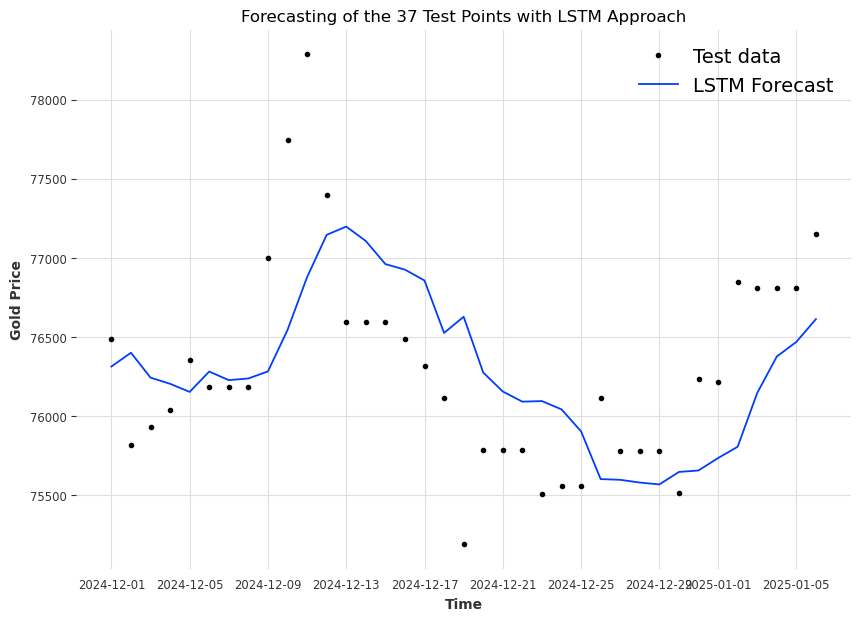

In [188]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=preds_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Points with LSTM Approach')
plt.show()

In [189]:
lstm_metrics = evaluate_preds(y_true=y_test,
                              y_pred=preds_lstm)
lstm_metrics

{'mae': np.float32(471.0494),
 'mse': np.float32(332326.5),
 'rmse': np.float32(576.47766),
 'mape': np.float32(0.6159355)}

#### Evaluate Overfitting

In [190]:
holdout_exogenus_scaled_train = gold_price_exogenus_darts_scaled_train.slice(
    gold_price_exogenus_darts_scaled_train.time_index[2*split_size+1],
    gold_price_exogenus_darts_scaled_train.time_index[split_size]
)
not_holdout_exogenus_scaled_train = gold_price_exogenus_darts_scaled_train.slice(
    gold_price_darts_train.time_index[0],
    gold_price_darts_train.time_index[2*split_size]
)

In [191]:
preds_holdout_train_lstm = make_predictions_rolling_one_darts(ts_train=not_holdout_scaled_train,
                                                  ts_test=holdout_scaled_train,
                                                  ts_exogenus_train=not_holdout_exogenus_scaled_train,
                                                  ts_exogenus_test=holdout_exogenus_scaled_train,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_lstm)

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.37it/s]


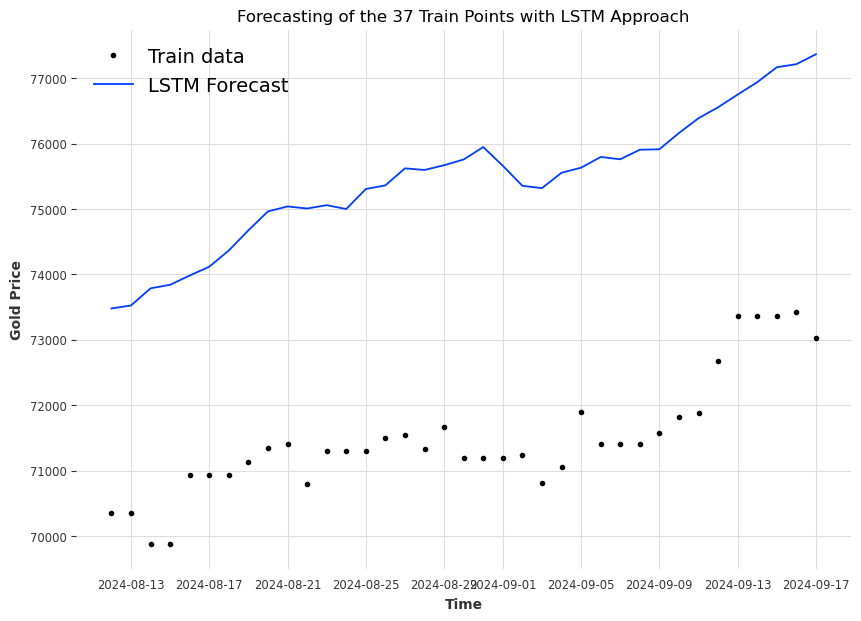

In [192]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[2*split_size:split_size], values=y_train[2*split_size:split_size], label="Train data", start=0, end=50)
plot_time_series(timesteps=X_train[2*split_size:split_size], values=preds_holdout_train_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Train Points with LSTM Approach')
plt.show()

In [193]:
lstm_train_metrics = evaluate_preds(y_pred=preds_holdout_train_lstm,
                                      y_true=y_train[2*split_size:split_size])
lstm_train_metrics

{'mae': np.float32(3956.2915),
 'mse': np.float32(15856899.0),
 'rmse': np.float32(3982.0723),
 'mape': np.float32(5.534618)}

### GRU - Gated Recurrent Unit Neural Network

#### Create Model

In [194]:
model_gru = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=32,
    n_rnn_layers=2,
    dropout=0.1,
    batch_size=16,
    n_epochs=10
)

In [195]:
model_gru.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 0:   0%|          | 1/248 [00:00<00:09, 25.59it/s, train_loss=0.145]

Epoch 9: 100%|██████████| 248/248 [00:05<00:00, 44.70it/s, train_loss=0.000277]


RNNModel(model=GRU, hidden_dim=32, n_rnn_layers=2, dropout=0.1, training_length=30, input_chunk_length=30, batch_size=16, n_epochs=10)

#### Make Predictions

In [196]:
preds_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.62it/s]


#### Evaluate Predictions

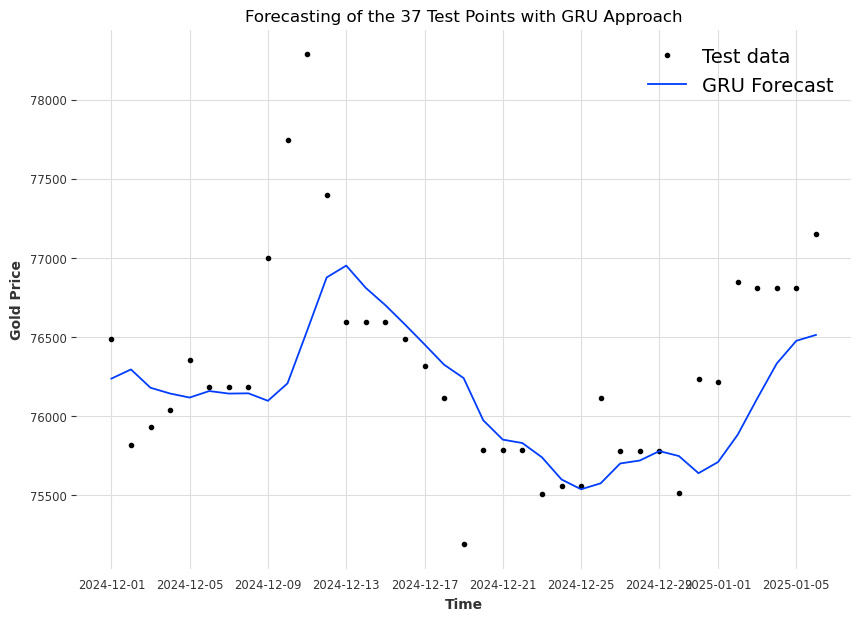

In [197]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=preds_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title('Forecasting of the 37 Test Points with GRU Approach')
plt.show()

In [198]:
gru_metrics = evaluate_preds(y_true=y_test,
                            y_pred=preds_gru)
gru_metrics

{'mae': np.float32(379.59058),
 'mse': np.float32(311412.06),
 'rmse': np.float32(558.0431),
 'mape': np.float32(0.49450332)}

#### Evaluate Overfitting

In [199]:
preds_holdout_train_gru = make_predictions_rolling_one_darts(ts_train=not_holdout_scaled_train,
                                                  ts_test=holdout_scaled_train,
                                                  ts_exogenus_train=not_holdout_exogenus_scaled_train,
                                                  ts_exogenus_test=holdout_exogenus_scaled_train,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.20it/s]


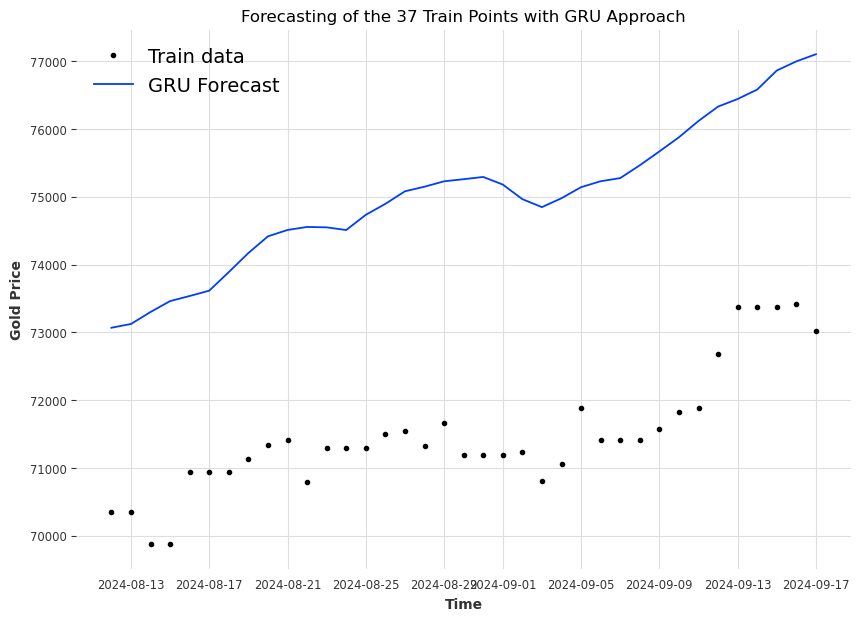

In [200]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[2*split_size:split_size], values=y_train[2*split_size:split_size], label="Train data", start=0, end=50)
plot_time_series(timesteps=X_train[2*split_size:split_size], values=preds_holdout_train_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Train Points with GRU Approach')
plt.show()

In [201]:
gru_train_metrics = evaluate_preds(y_pred=preds_holdout_train_gru,
                                      y_true=y_train[2*split_size:split_size])
gru_train_metrics

{'mae': np.float32(3519.2031),
 'mse': np.float32(12593376.0),
 'rmse': np.float32(3548.7146),
 'mape': np.float32(4.9221234)}

### N-BEATSx

#### Create Model

In [202]:
model_nbeatsx = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    n_epochs=10,
    random_state=42
)

model_nbeatsx.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 9: 100%|██████████| 124/124 [00:21<00:00,  5.70it/s, train_loss=0.000326]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=10, random_state=42)

#### Make Predictions

In [203]:
from utils.preds import make_predictions_rolling_one_past_covariates_darts

In [204]:
preds_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


#### Evaluate Predictions

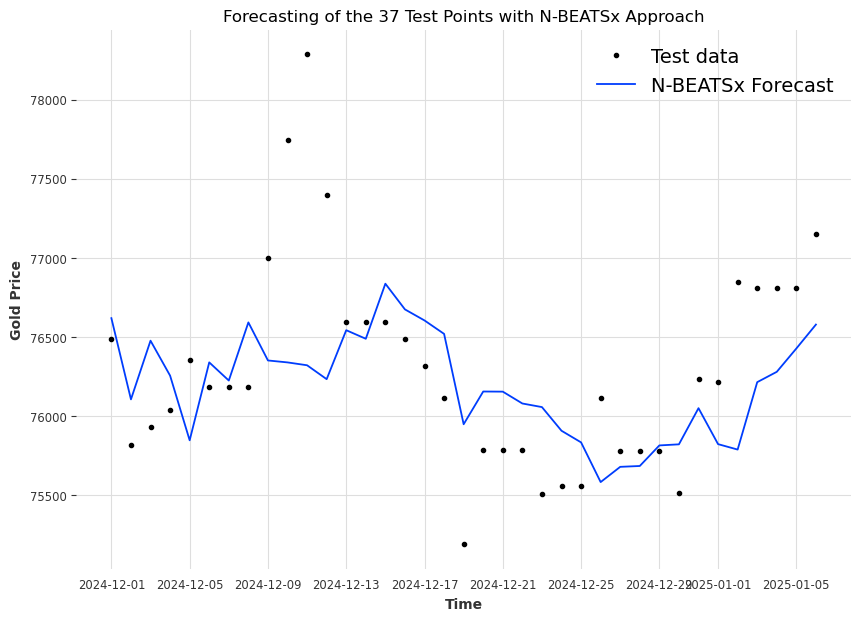

In [205]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=preds_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title('Forecasting of the 37 Test Points with N-BEATSx Approach')
plt.show()

In [206]:
nbeatsx_metrics = evaluate_preds(y_true=y_test,
                            y_pred=preds_nbeatsx)
nbeatsx_metrics

{'mae': np.float32(446.20038),
 'mse': np.float32(354536.06),
 'rmse': np.float32(595.4293),
 'mape': np.float32(0.5819175)}

#### Evaluate Overfitting

In [207]:
preds_holdout_train_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=not_holdout_scaled_train,
                                                  ts_test=holdout_scaled_train,
                                                  ts_exogenus_train=not_holdout_exogenus_scaled_train,
                                                  ts_exogenus_test=holdout_exogenus_scaled_train,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


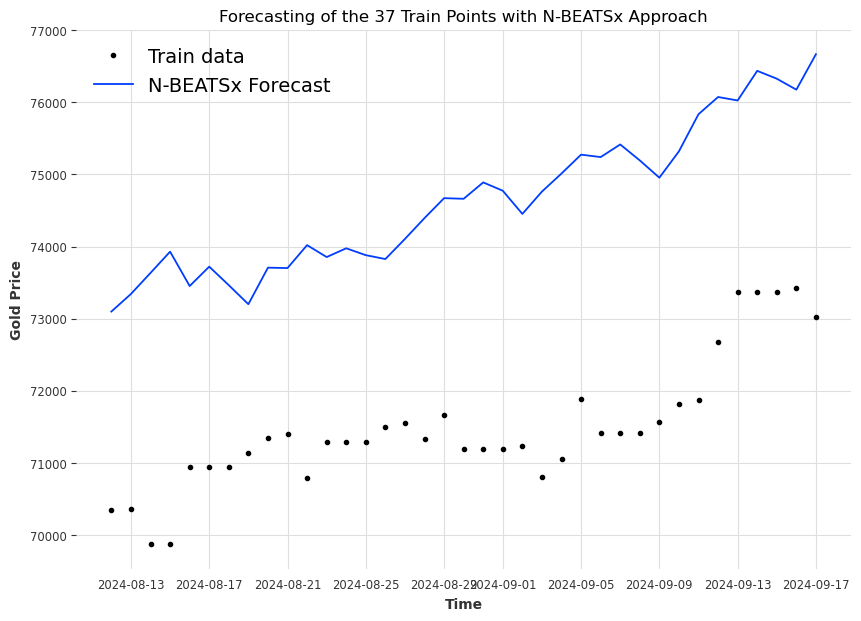

In [208]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[2*split_size:split_size], values=y_train[2*split_size:split_size], label="Train data", start=0, end=50)
plot_time_series(timesteps=X_train[2*split_size:split_size], values=preds_holdout_train_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Train Points with N-BEATSx Approach')
plt.show()

In [209]:
nbeatsx_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeatsx,
                                      y_true=y_train[2*split_size:split_size])
nbeatsx_train_metrics

{'mae': np.float32(3143.32),
 'mse': np.float32(10202145.0),
 'rmse': np.float32(3194.0796),
 'mape': np.float32(4.39864)}